In [1]:
# !pip install einops torch maze-dataset --q

In [1]:
import os
import random
import numpy as np
import torch
import matplotlib.pyplot as plt

from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torch.nn import functional as F
from PIL import Image
from maze_dataset.plotting import MazePlot

In [2]:
os.chdir("../")
print(f"Current working directory: {os.getcwd()}")

Current working directory: /Users/I749793/Desktop/NUS/Uncertainty Modeling in AI/project/diffusion-based-environment-generator


## Loading the Dataset

In [3]:
# from maze.maze_generator import generate_dataset

# n_mazes = 10000
# directory = "./data/"

# generate_dataset(n_mazes, directory) ,

# print("Maze dataset generation complete!")

In [4]:
def preprocess_image(image, target_size=32):
    image = np.array(image)
    
    scale_factor = target_size // image.shape[0] 
    image = np.kron(image, np.ones((scale_factor, scale_factor, 1))) 
    
    image = image.astype(np.float32) / 127.5 - 1
    image = torch.tensor(image).permute(2, 0, 1)
    return image

def load_dataset_from_npy(directory="./data", target_size=32):
    images = []
    path_lengths = []
    
    files = sorted([f for f in os.listdir(directory) if f.endswith(".npy")])
    
    for file in files:
        img = np.load(os.path.join(directory, file))
        
        mask = np.all(img == [0, 0, 255], axis=-1)
        img[mask] = [255, 255, 255]
        img = img[:-1, :-1] 
        
        image = preprocess_image(img, target_size)
        
        base_name = os.path.splitext(file)[0]
        len_filename = base_name + "_len.txt"
        len_path = os.path.join(directory, len_filename)
        
        with open(len_path, "r") as f:
            maze_length = int(f.read().strip())
        
        images.append(image)
        path_lengths.append(maze_length)
    
    return images, path_lengths

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


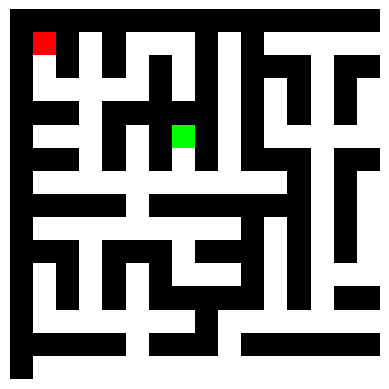

In [5]:
# mazes_data_path = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), "data", "mazes")
mazes_data_path = "./data/mazes"
images, path_lengths = load_dataset_from_npy(mazes_data_path, target_size=32)

plt.imshow(images[0].permute(1, 2, 0).cpu().numpy(), cmap='gray')
plt.axis('off')
plt.show()

class MazeTensorDataset(Dataset):
    def __init__(self, images, path_lengths):
        self.images = images
        self.path_lengths = path_lengths
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        return self.images[idx], self.path_lengths[idx]

# Diffusion

In [6]:
os.chdir("./diffuser")
print(f"Current working directory: {os.getcwd()}")

Current working directory: /Users/I749793/Desktop/NUS/Uncertainty Modeling in AI/project/diffusion-based-environment-generator/diffuser


### VAE Training

In [7]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from maze_dataset.plotting import MazePlot
import random

In [8]:
import importlib
import encoder
import decoder
importlib.reload(encoder)
importlib.reload(decoder)
from encoder import VAE_Encoder
from decoder import VAE_Decoder

In [9]:
# Hyperparameters
BATCH_SIZE = 128
LEARNING_RATE = 1e-4
EPOCHS = 150
LATENT_CHANNELS = 4

In [10]:
print("Total images:", len(images))
print("Total path_lengths:", len(path_lengths))

total = len(images)
test_size = int(0.2 * total)
all_indices = list(range(total))
random.shuffle(all_indices)

test_indices = all_indices[:test_size]
train_indices = all_indices[test_size:]

train_images = [images[i] for i in train_indices]
train_path_lengths = [path_lengths[i] for i in train_indices]

test_images = [images[i] for i in test_indices]
test_path_lengths = [path_lengths[i] for i in test_indices]

dataset = MazeTensorDataset(train_images, train_path_lengths)
test_dataset = MazeTensorDataset(test_images, test_path_lengths)

print("Train dataset length:", len(dataset))
print("Test dataset length:", len(test_dataset))

dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

unique_train_paths = set(train_path_lengths)
print("Unique training path lengths:", unique_train_paths)
print("Number of unique training paths:", len(unique_train_paths))

unique_test_paths = set(test_path_lengths)
print("Unique test path lengths:", unique_test_paths)
print("Number of unique test paths:", len(unique_test_paths))

Total images: 1000
Total path_lengths: 1000
Train dataset length: 800
Test dataset length: 200
Unique training path lengths: {2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24}
Number of unique training paths: 23
Unique test path lengths: {2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 26}
Number of unique test paths: 22


Epoch [1/150], Train Loss: 1137.4648
Epoch [2/150], Train Loss: 392.9487
Epoch [3/150], Train Loss: 269.0751
Epoch [4/150], Train Loss: 232.1780
Epoch [5/150], Train Loss: 215.6939
Epoch [6/150], Train Loss: 206.2240
Epoch [7/150], Train Loss: 199.6295
Epoch [8/150], Train Loss: 195.7053
Epoch [9/150], Train Loss: 192.6756
Epoch [10/150], Train Loss: 184.0845
Epoch [11/150], Train Loss: 177.6627
Epoch [12/150], Train Loss: 176.0582
Epoch [13/150], Train Loss: 173.9077
Epoch [14/150], Train Loss: 172.0976
Epoch [15/150], Train Loss: 169.7764
Epoch [16/150], Train Loss: 169.1628
Epoch [17/150], Train Loss: 162.8941
Epoch [18/150], Train Loss: 157.7942
Epoch [19/150], Train Loss: 155.4068
Epoch [20/150], Train Loss: 153.6920
Epoch [21/150], Train Loss: 152.6544
Epoch [22/150], Train Loss: 153.2517
Epoch [23/150], Train Loss: 150.7713
Epoch [24/150], Train Loss: 149.8337
Epoch [25/150], Train Loss: 149.1387
Epoch [26/150], Train Loss: 146.3264
Epoch [27/150], Train Loss: 144.2084
Epoch [28

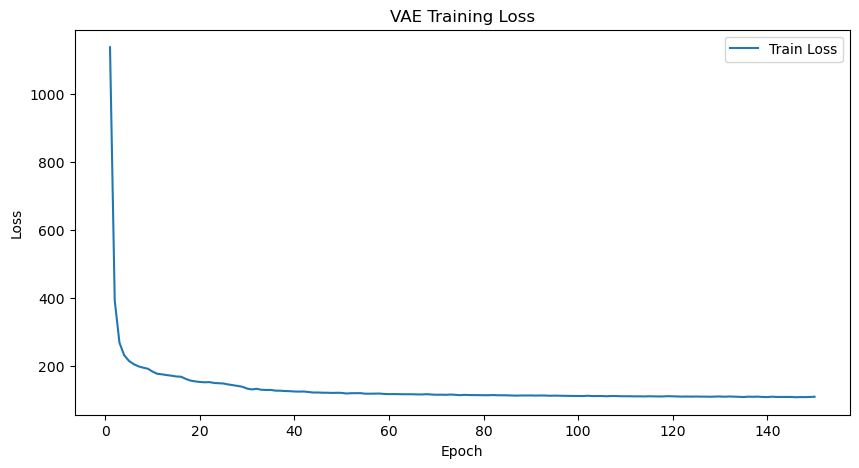

In [12]:
# Model Initialization
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder = VAE_Encoder().to(device)
decoder = VAE_Decoder().to(device)
optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=LEARNING_RATE)

def vae_loss(x, x_hat, mean, log_var):
    recon_loss = nn.functional.mse_loss(x_hat, x, reduction='sum') / x.size(0)
    
    kl_loss = 0.5 * (mean.pow(2) + log_var.exp() - log_var - 1).sum(dim=(1, 2, 3)).mean()
    
    return recon_loss + kl_loss

train_losses = []
for epoch in range(EPOCHS):
    encoder.train()
    decoder.train()
    train_loss = 0.0
    
    for batch_idx, x in enumerate(dataloader):
        
        x = x[0].to(device)
        batch_size = x.size(0)
        
        noise = torch.randn(batch_size, LATENT_CHANNELS, 8, 8).to(device)
        
        mean, log_var, z = encoder(x, noise)
        x_hat = decoder(z)
        
        loss = vae_loss(x, x_hat, mean, log_var)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * batch_size
        
    train_loss = train_loss / len(dataloader.dataset)
    train_losses.append(train_loss)
    print(f'Epoch [{epoch+1}/{EPOCHS}], Train Loss: {train_loss:.4f}')

plt.figure(figsize=(10, 5))
plt.plot(range(1, EPOCHS + 1), train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('VAE Training Loss')
plt.legend()
plt.show()

### VAE Testing

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0963074..1.1554965].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [7.1525574e-07..1.986552].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1306598..1.0582229].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0701884..1.0910589].
Clipping input data

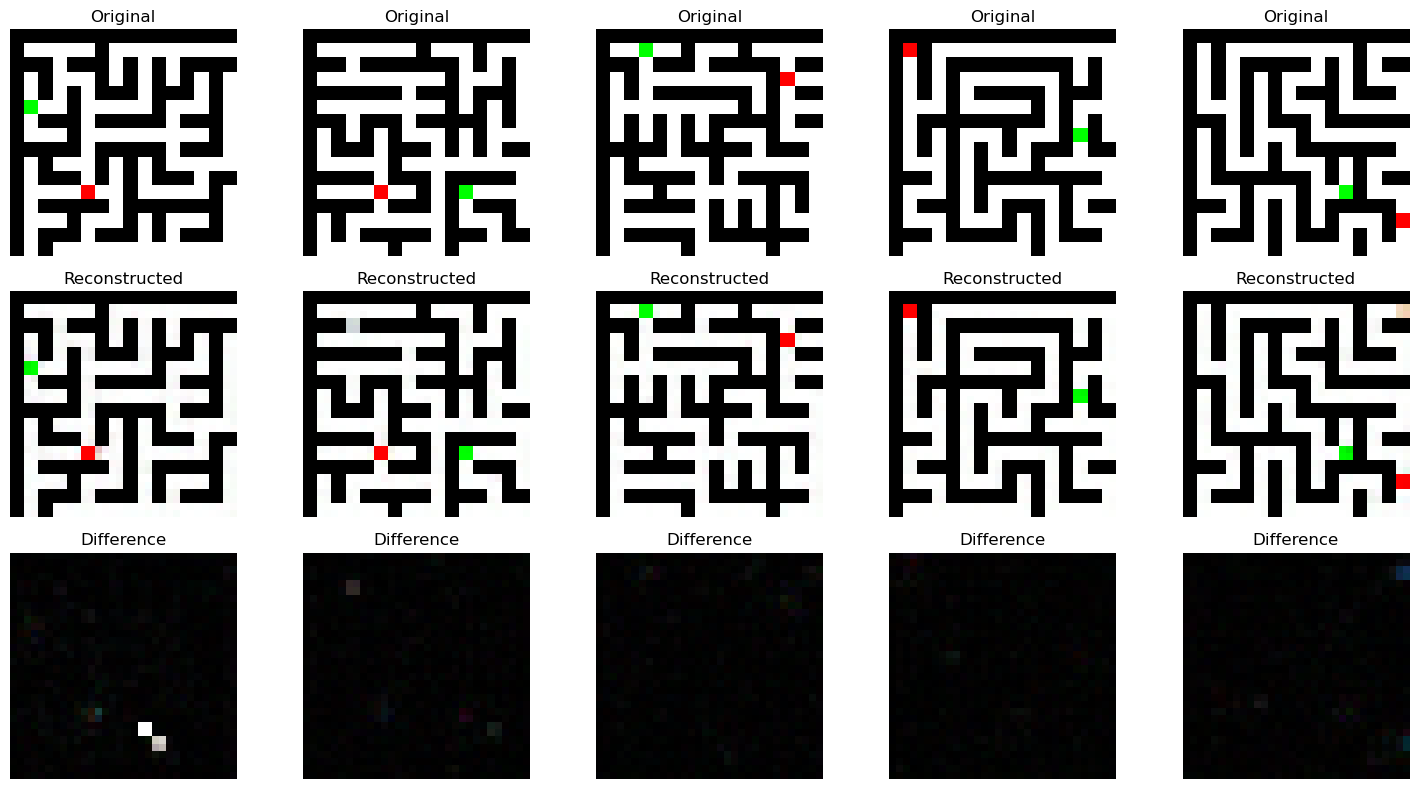

In [14]:
encoder.eval()
decoder.eval()

with torch.no_grad():
    fig, axes = plt.subplots(3, 5, figsize=(15, 8))
    for i in range(5):
        idx = np.random.randint(len(test_dataset))
        img, _ = test_dataset[idx]  # Ignore the path length label for reconstruction
        img = img.unsqueeze(0).to(device)
        noise = torch.randn(1, LATENT_CHANNELS, 8, 8).to(device)
        
        _, _, z = encoder(img, noise)
        reconstructed = decoder(z).cpu().squeeze(0)
        
        original = img.cpu().squeeze(0)
        
        difference = torch.abs(original - reconstructed)
        
        axes[0, i].imshow(original.permute(1, 2, 0).numpy(), cmap='gray')
        axes[0, i].axis('off')
        axes[0, i].set_title('Original')
        
        axes[1, i].imshow(reconstructed.permute(1, 2, 0).numpy(), cmap='gray')
        axes[1, i].axis('off')
        axes[1, i].set_title('Reconstructed')
        
        axes[2, i].imshow(difference.permute(1, 2, 0).numpy(), cmap='gray')
        axes[2, i].axis('off')
        axes[2, i].set_title('Difference')
    
    plt.tight_layout()
    plt.show()

In [15]:
!ls

attention.py  decoder.py  experiments.ipynb  pipeline.py
ddpm.py       encoder.py  model.py	     __pycache__


In [16]:
# Save Model Weights
torch.save({
    'encoder_state_dict': encoder.state_dict(),
    'decoder_state_dict': decoder.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, 'vae_weights_1.pth')

print("Model weights saved to vae_weights_1.pth")

Model weights saved to vae_weights_1.pth


## UNET

### UNET Training

In [11]:
# Hyperparameters
BATCH_SIZE = 128
EPOCHS = 75
NUM_TIMESTEPS = 1000
LATENT_CHANNELS = 4

In [12]:
print("Total images:", len(images))
print("Total path_lengths:", len(path_lengths))

total = len(images)
test_size = int(0.2 * total)
all_indices = list(range(total))
random.shuffle(all_indices)

test_indices = all_indices[:test_size]
train_indices = all_indices[test_size:]

train_images = [images[i] for i in train_indices]
train_path_lengths = [path_lengths[i] for i in train_indices]

test_images = [images[i] for i in test_indices]
test_path_lengths = [path_lengths[i] for i in test_indices]

dataset = MazeTensorDataset(train_images, train_path_lengths)
test_dataset = MazeTensorDataset(test_images, test_path_lengths)

print("Train dataset length:", len(dataset))
print("Test dataset length:", len(test_dataset))

dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

unique_train_paths = set(train_path_lengths)
print("Unique training path lengths:", unique_train_paths)
print("Number of unique training paths:", len(unique_train_paths))

unique_test_paths = set(test_path_lengths)
print("Unique test path lengths:", unique_test_paths)
print("Number of unique test paths:", len(unique_test_paths))

Total images: 1000
Total path_lengths: 1000
Train dataset length: 800
Test dataset length: 200
Unique training path lengths: {2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24}
Number of unique training paths: 22
Unique test path lengths: {2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 26}
Number of unique test paths: 22


In [16]:
import importlib
import encoder
import decoder
import model
importlib.reload(encoder)
importlib.reload(decoder)
importlib.reload(model)
from encoder import VAE_Encoder
from decoder import VAE_Decoder
from model import Diffusion
from ddpm import DDPMSampler
# from classifier_guidance.models import Classifier

device = "cuda" if torch.cuda.is_available() else "cpu"

vae_encoder = VAE_Encoder().to(device).eval()
decoder = VAE_Decoder().to(device).eval()

# checkpoint = torch.load('vae_weights_1.pth', map_location=device)
# vae_encoder.load_state_dict(checkpoint['encoder_state_dict'])
# decoder.load_state_dict(checkpoint['decoder_state_dict'])

diffusion_model = Diffusion().to(device)
optimizer = torch.optim.Adam(diffusion_model.parameters(), lr=1e-4, weight_decay=0.01)
scheduler = DDPMSampler(generator=torch.Generator(device=device), num_training_steps=NUM_TIMESTEPS)

In [17]:
dummy_tensor  = None
for batch_idx, (images, path_lengths) in enumerate(dataloader):
    dummy_tensor = path_lengths
zeros_tensor = torch.zeros_like(dummy_tensor).to(device)

print(dummy_tensor.shape)
context = diffusion_model.condition_embedding(dummy_tensor)
empty_embeddings = diffusion_model.condition_embedding(zeros_tensor)
classifier_guidance_embeddings = torch.cat([empty_embeddings, context])
print(classifier_guidance_embeddings.shape)

torch.Size([32])
torch.Size([64, 1, 768])


In [86]:
# classifier_guidance_embeddings.unsqueeze(-1).permute(0, 2, 1, 3)

torch.Size([42, 768, 1, 1])

In [92]:
# images.shape

torch.Size([21, 3, 32, 32])

In [96]:
# images.repeat(2, 1, 1, 1).chunk(2)[1].shape

torch.Size([21, 3, 32, 32])

In [61]:
# bs_embed, seq_len, _ = classifier_guidance_embeddings.shape
# prompt_embeds = classifier_guidance_embeddings.repeat(1, 1, 1)
# prompt_embeds = prompt_embeds.view(bs_embed * 1, seq_len, -1)
# prompt_embeds.shape

torch.Size([42, 1, 768])

/tmp/ipykernel_894984/4087168046.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  path_lengths = torch.tensor(path_lengths).float().to(device)


Epoch [1/75], Loss: 0.0944
Epoch [2/75], Loss: 0.0498
Epoch [3/75], Loss: 0.0427
Epoch [4/75], Loss: 0.0389
Epoch [5/75], Loss: 0.0392
Epoch [6/75], Loss: 0.0384
Epoch [7/75], Loss: 0.0394
Epoch [8/75], Loss: 0.0385
Epoch [9/75], Loss: 0.0385
Epoch [10/75], Loss: 0.0382
Epoch [11/75], Loss: 0.0375
Epoch [12/75], Loss: 0.0381
Epoch [13/75], Loss: 0.0384
Epoch [14/75], Loss: 0.0374
Epoch [15/75], Loss: 0.0380
Epoch [16/75], Loss: 0.0375
Epoch [17/75], Loss: 0.0386
Epoch [18/75], Loss: 0.0383
Epoch [19/75], Loss: 0.0377
Epoch [20/75], Loss: 0.0374
Epoch [21/75], Loss: 0.0370
Epoch [22/75], Loss: 0.0370
Epoch [23/75], Loss: 0.0383
Epoch [24/75], Loss: 0.0380
Epoch [25/75], Loss: 0.0386
Epoch [26/75], Loss: 0.0373
Epoch [27/75], Loss: 0.0368
Epoch [28/75], Loss: 0.0386
Epoch [29/75], Loss: 0.0381
Epoch [30/75], Loss: 0.0386
Epoch [31/75], Loss: 0.0370
Epoch [32/75], Loss: 0.0371
Epoch [33/75], Loss: 0.0375
Epoch [34/75], Loss: 0.0602
Epoch [35/75], Loss: 0.0436
Epoch [36/75], Loss: 0.0369
E

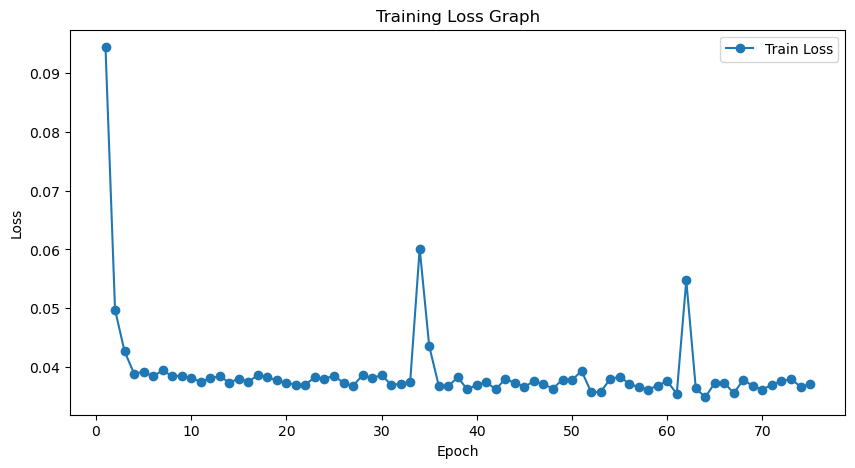

In [11]:
train_losses = []
GUIDANCE_SCALE = 7.5

for epoch in range(EPOCHS):
    epoch_loss = 0.0
    count = 0
    for batch_idx, (images, path_lengths) in enumerate(dataloader):
        images = images.to(device)
        path_lengths = torch.tensor(path_lengths).float().to(device)
        zeros_tensor = torch.zeros_like(path_lengths).to(device)
        
        noise = torch.randn(images.size(0), LATENT_CHANNELS, 8, 8, device=device)
        
        with torch.no_grad():
            _, _, z = vae_encoder(images, noise)
        
        timesteps = torch.randint(0, NUM_TIMESTEPS, (z.size(0),), device=device)
        
        noisy_z, noise_used = scheduler.add_noise(z, timesteps)
        # to accomoatde for classifier free guidance.
        noisy_z = noisy_z.repeat(2, 1, 1, 1)
        
        # this is the context embedding that the model should move towards
        context = diffusion_model.condition_embedding(path_lengths)

        # something like the a negative prompt.
        unconditional_guidance_embeddings = diffusion_model.condition_embedding(zeros_tensor)
        conditional_guidance_embeddings = torch.cat([unconditional_guidance_embeddings, context])
        

        # noise_pred = diffusion_model(noisy_z, context, timesteps)
        noise_pred = diffusion_model(noisy_z, conditional_guidance_embeddings, timesteps)
        noise_pred_uncond, noise_pred_cond = noise_pred.chunk(2)

        noise_pred = noise_pred_uncond + GUIDANCE_SCALE * (noise_pred_cond - noise_pred_uncond)
        
        # loss = F.mse_loss(noise_pred, noise_used)
        loss = F.smooth_l1_loss(noise_pred, noise_used)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item() * images.size(0)
        count += images.size(0)
    
    avg_loss = epoch_loss / count if count > 0 else 0.0
    train_losses.append(avg_loss)
    print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {avg_loss:.4f}")

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(range(1, EPOCHS + 1), train_losses, marker='o', label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Graph')
plt.legend()
plt.show()

In [12]:
torch.save({
    'diffusion_state_dict': diffusion_model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_losses': train_losses
}, 'diffusion_weights.pth')
print("Diffusion weights saved to diffusion_weights.pth")

Diffusion weights saved to diffusion_weights.pth


### UNET TESTING

In [13]:
def generate_maze_from_test(sample_idx=None, num_steps=50):
    diffusion_model.eval()
    scheduler.set_inference_timesteps(num_steps)
    
    if sample_idx is None:
        sample_idx = random.randint(0, len(test_dataset) - 1)
    
    test_img, test_path_length = test_dataset[sample_idx]
    
    context = diffusion_model.condition_embedding(
        torch.tensor([test_path_length], device=device).float()
    )
    
    latent = torch.randn((1, 4, 8, 8), device=device)
    
    for t in scheduler.timesteps:
        timestep = torch.tensor([t], device=device)
        with torch.no_grad():
            pred = diffusion_model(latent, context, timestep)
        latent = scheduler.step(t, latent, pred)
    
    with torch.no_grad():
        generated_image = decoder(latent / 0.18215)
    
    return generated_image, test_img, test_path_length

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.656992..1.4219905].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


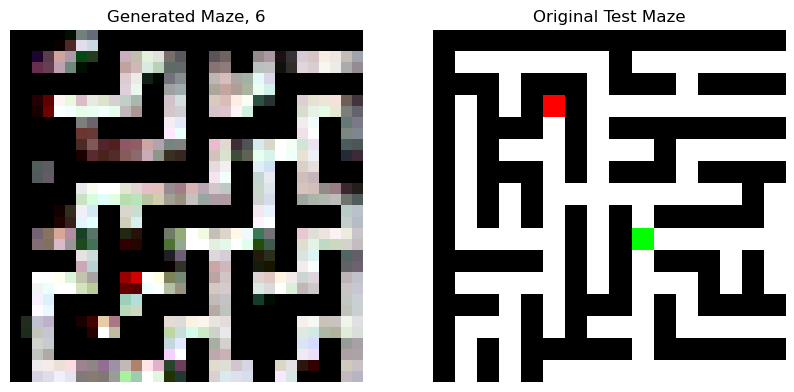

In [16]:
generated, original, test_path_length = generate_maze_from_test(num_steps=100)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(generated.squeeze(0).permute(1, 2, 0).cpu().numpy(), cmap='gray')
plt.title(f"Generated Maze, {test_path_length}")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(original.permute(1, 2, 0).cpu().numpy(), cmap='gray')
plt.title("Original Test Maze")
plt.axis("off")
plt.show()